In [ ]:
!pip install -qU langchain-groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.7/109.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 15.5 MB/s eta 0:00:00



Query 1: What is 3 * 12? Also, what is 11 + 49?
🛠 Tool Called: multiply
🛠 Tool Called: add
Response: Easy ones!

3 * 12 = 36

11 + 49 = 60
Response: Easy math problems!

3 * 12 = 36

11 + 49 = 60

Query 2: What is 4 times 5? Add the answer to 3. Multiply the sum with 2.
🛠 Tool Called: multiply
Response: Let's follow the instructions:

4 times 5 is 20.
Adding 3 to 20 gives 23.
Multiplying 23 by 2 gives 46.

So the final answer is 46.

Query 3: Generate an image of a cyberpunk city at night.
🛠 Tool Called: generate_image


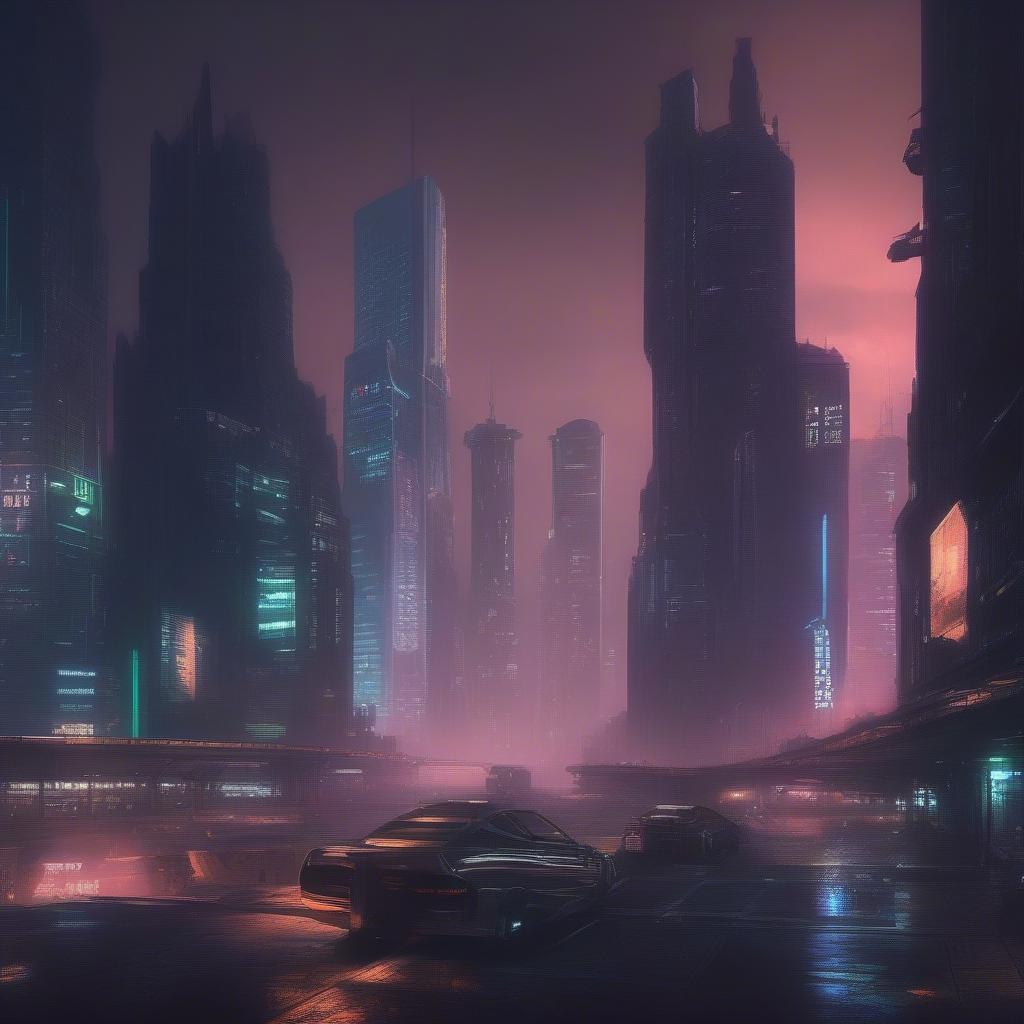


Query 4: What is 2 + 3?
🛠 Tool Called: add
Response: The answer to 2 + 3 is 5.


In [ ]:
import os
import getpass
import types
from typing_extensions import Annotated, TypedDict
from langchain_groq import ChatGroq
from huggingface_hub import InferenceClient
from PIL import Image
import io

# Set up API keys
if "GROQ_API_KEY" not in os.environ:
    os.environ["GROQ_API_KEY"] = getpass.getpass("Enter your Groq API key: ")

if "HF_API_KEY" not in os.environ:
    os.environ["HF_API_KEY"] = getpass.getpass("Enter your Hugging Face API key: ")

# Initialize LLM
llm_text = ChatGroq(model="llama3-8b-8192")  # For text processing

# Initialize Hugging Face Inference Client for image generation tasks
hf_client = InferenceClient(
    api_key=os.environ["HF_API_KEY"]
)

# Function to dynamically create a TypedDict for each tool
def create_typed_dict(name: str, description: str, fields: dict):
    annotations = {
        field: Annotated[field_type, ..., field_description]
        for field, (field_type, field_description) in fields.items()
    }

    new_typed_dict = types.new_class(
        name,
        (TypedDict,),
        {},
        lambda ns: ns.update({"__annotations__": annotations, "__doc__": description}),
    )
    return new_typed_dict

# Define user tools
user_defined_tools = [
    {
        "name": "add",
        "description": "Add two numbers.",
        "fields": {
            "a": (int, "First integer"),
            "b": (int, "Second integer"),
        },
    },
    {
        "name": "multiply",
        "description": "Multiply two numbers.",
        "fields": {
            "a": (int, "First integer"),
            "b": (int, "Second integer"),
        },
    },
    {
        "name": "generate_text",
        "description": "Generate a text response for a given prompt.",
        "fields": {
            "prompt": (str, "Prompt for text generation"),
        },
    },
    {
        "name": "generate_image",
        "description": "Generate an image with the given description.",
        "fields": {
            "prompt": (str, "Prompt for image generation"),
        },
    }
]

# Create TypedDict tools dynamically
tools = []
tool_descriptions = {}  # Store descriptions for prompt generation
for tool_info in user_defined_tools:
    tool = create_typed_dict(
        tool_info["name"],
        tool_info["description"],
        tool_info["fields"],
    )
    tools.append(tool)
    tool_descriptions[tool_info["name"]] = tool_info["description"]  # Store tool descriptions

# Bind tools to Llama for classification
llm_with_tools = llm_text.bind_tools(tools)

# determine tool types using Llama (support multiple tools)
def determine_tool_types(query):
    response = llm_with_tools.invoke(query)
    tool_calls = response.tool_calls if hasattr(response, "tool_calls") else []

    if not tool_calls:
        return [("generate_text", {"prompt": query})]  # Default to text generation if no tools found

    tool_args = []
    for tool_call in tool_calls:
        tool_args.append((tool_call["name"], tool_call["args"]))

    return tool_args

# Function to generate images using Hugging Face API
def generate_image(prompt):
    image = hf_client.text_to_image(
        prompt,
        model="stabilityai/stable-diffusion-xl-base-1.0"
    )
    return image  # PIL Image object

def process_query(query):
    tool_args = determine_tool_types(query)

    # Output the tools that were called
    for tool_name, args in tool_args:
        print(f"🛠 Tool Called: {tool_name}")

    responses = []
    for tool_name, args in tool_args:
        if tool_name == "generate_image":
            responses.append(generate_image(args["prompt"]))  # Returns PIL Image
        else:
            responses.append(llm_text.invoke(query).content)  # Invoke LLM for everything else

    return responses

# Example Queries
queries = [
    "What is 3 * 12? Also, what is 11 + 49?",
    "What is 4 times 5? Add the answer to 3. Multiply the sum with 2.",
    "Generate an image of a cyberpunk city at night.",
    "What is 2 + 3?"
]

# Process each query
for i, query in enumerate(queries):
    print(f"\nQuery {i+1}: {query}")
    responses = process_query(query)
    for response in responses:
        if isinstance(response, Image.Image): # if image, display it
            display(response)
        else:
            print("Response:", response)
